## Stock Price Prdictions and Analysis for Information Technology Companies

I initially chose the LSTM due to the volatile nature of the stock prices. LSTM(Long Short-Term Model) is proven to be good at predicting very volatile things due its mechanism.

In [20]:
#importing all the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas_ta
import tensorflow as tf
import joblib

# Extracting the dataset for Oracle

In [21]:
#importing the dataset for Oracle corporation from 2015 to the end of 2023
ticker = 'ORCL'
oracle_df = yf.download(ticker, start = '2015-01-01', end = '2023-12-31')
oracle_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,45.020000,45.189999,43.970001,44.330002,38.042271,15070200
2015-01-05,44.160000,44.250000,43.580002,43.590000,37.508762,18369400
2015-01-06,44.060001,44.180000,42.990002,43.139999,37.121536,19229500
2015-01-07,43.330002,43.520000,43.009998,43.150002,37.130135,13502200
2015-01-08,43.630001,43.939999,43.380001,43.410000,37.353870,17516900


# Checking the information and shape of the dataframe, and also if there are any null values which we might need to change

In [22]:
print(oracle_df.shape)
print(oracle_df.info()) #to check for all the datatypes of the features

(2264, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2264 non-null   float64
 1   High       2264 non-null   float64
 2   Low        2264 non-null   float64
 3   Close      2264 non-null   float64
 4   Adj Close  2264 non-null   float64
 5   Volume     2264 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB
None


In [23]:
print(oracle_df.duplicated().sum()) #to check for any duplicate rows that might exist

0


In [24]:
print(oracle_df.isnull().sum()) #to check for any null values 

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [25]:
print(oracle_df.describe()) #to get the summary statistics

              Open         High          Low        Close    Adj Close  \
count  2264.000000  2264.000000  2264.000000  2264.000000  2264.000000   
mean     60.497981    61.109779    59.959792    60.536025    56.624964   
std      21.557608    21.831025    21.307727    21.577619    22.577046   
min      33.799999    34.230000    33.130001    33.939999    29.655428   
25%      44.220001    44.645001    43.977500    44.317500    39.368253   
50%      52.995001    53.424999    52.430000    52.885000    48.912897   
75%      75.562498    76.577497    74.667503    75.810001    73.057699   
max     127.139999   127.540001   125.150002   126.709999   125.003235   

             Volume  
count  2.264000e+03  
mean   1.284404e+07  
std    7.572352e+06  
min    2.168200e+06  
25%    8.167250e+06  
50%    1.110380e+07  
75%    1.520105e+07  
max    7.913840e+07  


# APPROACH - 2 - Using OHLCV to predict stock prices

In [26]:
oracle_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,45.020000,45.189999,43.970001,44.330002,38.042271,15070200
2015-01-05,44.160000,44.250000,43.580002,43.590000,37.508762,18369400
2015-01-06,44.060001,44.180000,42.990002,43.139999,37.121536,19229500
2015-01-07,43.330002,43.520000,43.009998,43.150002,37.130135,13502200
2015-01-08,43.630001,43.939999,43.380001,43.410000,37.353870,17516900


Since volume has a negative correlation, we will drop it as a feature

In [27]:
oracle_df = oracle_df.reset_index()

# Adding some additional features that might prove to have a correlation with the target column

In [28]:
oracle_df['year']=oracle_df['Date'].apply(lambda x:x.year)
oracle_df['month']=oracle_df['Date'].apply(lambda x:x.month)
oracle_df['is_quarter_end'] = np.where(oracle_df['month']%3==0,1,0)

In [29]:
oracle_df['target'] = oracle_df['Adj Close'].shift(-1)
oracle_df = oracle_df.dropna(axis=0)
oracle_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,is_quarter_end,target
2258,2023-12-21,104.699997,105.930000,104.519997,105.860001,104.816238,8168000,2023,12,1,105.152885
2259,2023-12-22,105.699997,106.489998,105.459999,106.199997,105.152885,5678300,2023,12,1,105.142982
2260,2023-12-26,106.519997,106.650002,105.339996,106.190002,105.142982,5767400,2023,12,1,104.895454
2261,2023-12-27,106.320000,106.330002,105.559998,105.940002,104.895454,5627400,2023,12,1,105.202393
2262,2023-12-28,106.010002,106.610001,105.580002,106.250000,105.202393,5689100,2023,12,1,104.390488


In [30]:
oracle_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,is_quarter_end,target
0,2015-01-02,45.020000,45.189999,43.970001,44.330002,38.042271,15070200,2015,1,0,37.508762
1,2015-01-05,44.160000,44.250000,43.580002,43.590000,37.508762,18369400,2015,1,0,37.121536
2,2015-01-06,44.060001,44.180000,42.990002,43.139999,37.121536,19229500,2015,1,0,37.130135
3,2015-01-07,43.330002,43.520000,43.009998,43.150002,37.130135,13502200,2015,1,0,37.353870
4,2015-01-08,43.630001,43.939999,43.380001,43.410000,37.353870,17516900,2015,1,0,37.336651


In [31]:
oracle_df = oracle_df.set_index('Date')

Seeing how much each feature is correlated to the target column

In [32]:
oracle_df.corr()['target']

Open              0.997408
High              0.997974
Low               0.997702
Close             0.998117
Adj Close         0.998779
Volume           -0.280813
year              0.887919
month             0.119758
is_quarter_end    0.006921
target            1.000000
Name: target, dtype: float64

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(oracle_df)

In [34]:
training_data_len = int(np.ceil(len(oracle_df) * .7))

In [35]:
# Preparing the df for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Features for the past 'time_step' days
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Predicting the price
    return np.array(dataX), np.array(dataY)

In [36]:
time_step = 10  # Number of past days to consider
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [37]:
X_train, X_test = X[0:training_data_len], X[training_data_len:len(X)]
y_train, y_test = y[0:training_data_len], y[training_data_len:len(y)]

In [38]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data = (X_test, y_test))


C:\Users\anshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 2/5
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.8687e-04 - val_loss: 0.0021
Epoch 3/5
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.0053e-04 - val_loss: 6.6330e-04
Epoch 4/5
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3877e-04 - val_loss: 4.7499e-04
Epoch 5/5
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4108e-04 - val_loss: 2.5226e-04


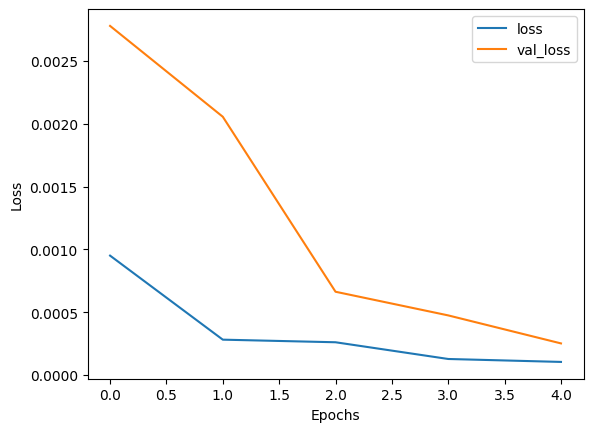

In [39]:
# Plotting the validation and training losses
losses=pd.DataFrame(model.history.history)
losses.plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Seeing the actual values of the price compared to the Predicted values of price in a graph

In [40]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X.shape[2] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X.shape[2] - 1))), axis=1))[:, 0]
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2] - 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2] - 1))), axis=1))[:, 0]


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


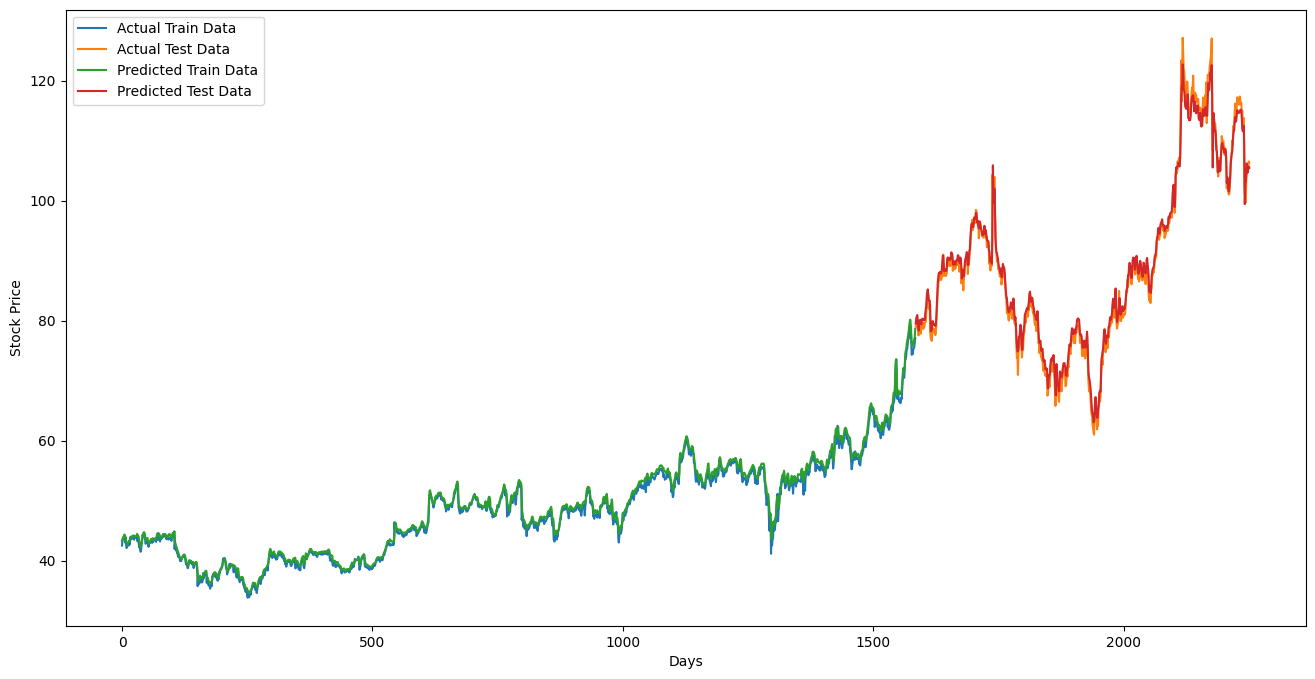

In [41]:
# Plotting the results
plt.figure(figsize=(16, 8))
plt.plot(y_train_inv, label='Actual Train Data')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, label='Actual Test Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predicted Test Data')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [43]:
# Calculating RMSE and MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
train_mae = mean_absolute_error(y_train_inv, train_predict)
test_mae = mean_absolute_error(y_test_inv, test_predict)

In [44]:
# Printing RMSE and MAE
print(f'Mean Absolute Error (MAE) - Second: {test_mae}')
print(f'Root Mean Squared Error (RMSE) - Second: {test_rmse}')

Mean Absolute Error (MAE) - Second: 1.1527397567242263
Root Mean Squared Error (RMSE) - Second: 1.482491054384828


# Saving the model and scalar for future use

In [45]:
model.save('ohlcv_model.h5')
joblib.dump(scaler, 'ohlcv_scaler.pkl')

['ohlcv_scaler.pkl']